## Loading a dataset from Hugging Face Hub

In [1]:
!pip install -q datasets pandas pydantic tqdm


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from datasets import load_dataset

ds_dict = load_dataset("microsoft/cats_vs_dogs")
ds_dict

/home/stefan/laborator/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})

#### Exploring the dataset

In [4]:
from pprint import pprint

ds = ds_dict["train"]
print('Dataset:')
pprint(ds)

print('\nFeatures:')
pprint(ds.features)

print('\nFirst item:')
pprint(ds.take(1)[0])

Dataset:
Dataset({
    features: ['image', 'labels'],
    num_rows: 23410
})

Features:
{'image': Image(mode=None, decode=True, id=None),
 'labels': ClassLabel(names=['cat', 'dog'], id=None)}

First item:
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7A8081784070>,
 'labels': 0}


#### Adding a new column to the dataset

In [5]:
def add_name(example):
    example["animal"] = ds.features['labels'].int2str(example["labels"])
    return example

# add a new column to the dataset
ds = ds.map(add_name)
ds.features

{'image': Image(mode=None, decode=True, id=None),
 'labels': ClassLabel(names=['cat', 'dog'], id=None),
 'animal': Value(dtype='string', id=None)}

#### Shuffling and consuming the dataset

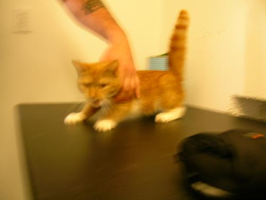

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7A80817D7280>, 'labels': 0, 'animal': 'cat'}


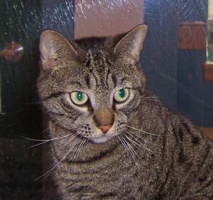

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x281 at 0x7A80817D7850>, 'labels': 0, 'animal': 'cat'}


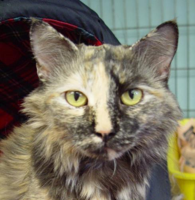

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=489x500 at 0x7A80817F8190>, 'labels': 0, 'animal': 'cat'}


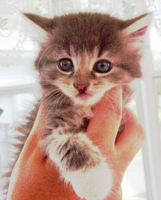

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=403x500 at 0x7A80817FB0A0>, 'labels': 0, 'animal': 'cat'}


In [6]:
from IPython.display import display

# take a look at the first 10 items
for item in ds.take(4):
    image = item["image"]
    display(image.resize((int(image.width/image.height * 200), 200)))
    print(item)


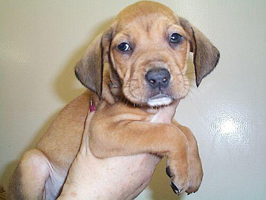

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7A80817F8520>, 'labels': 1, 'animal': 'dog'}


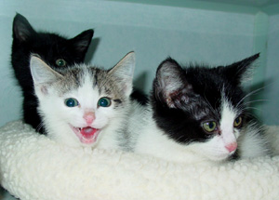

{'image': <PIL.Image.Image image mode=RGB size=300x215 at 0x7A807CD5AE60>, 'labels': 0, 'animal': 'cat'}


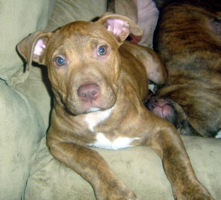

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x451 at 0x7A8081768160>, 'labels': 1, 'animal': 'dog'}


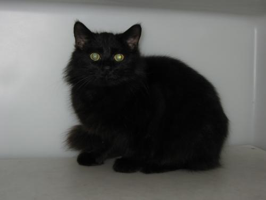

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7A80817F8A90>, 'labels': 0, 'animal': 'cat'}


In [7]:
# shuffleing the dataset for more interesting results
ds = ds.shuffle(seed=19)

# take a look at the first 10 items
for item in ds.take(4):
    image = item["image"]
    display(image.resize((int(image.width/image.height * 200), 200)))
    print(item)

#### Saving the dataset to the local file system

Let's take 100 items and save them to the local file system.

This will same them as `pyarrow`, a format commonly used by huggingface's `datasets` library

In [24]:
small_ds = ds.take(100)
small_ds.save_to_disk("./data/cats_vs_dogs_100")

Saving the dataset (1/1 shards): 100%|██████████| 100/100 [00:00<00:00, 5077.73 examples/s]


Let's also save the dataset to the disk as files, so that we learn how to load them back.

In [30]:
import os
small_ds_files_path = "./data/cats_vs_dogs_100_files"

os.makedirs(small_ds_files_path, exist_ok=True)

for index, item in enumerate(small_ds):
    image = item["image"]
    image.save(f"{small_ds_files_path}/{index}.jpg")

# select columns that are not the image and save them as a CSV file
small_ds.select_columns(["labels", "animal"]).to_csv(f"{small_ds_files_path}/data.csv")

!ls -la ./data/cats_vs_dogs_100_files | tail -n 10

Creating CSV from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 669.48ba/s]

-rw-r--r-- 1 stefan stefan 43622 Oct 19 09:07 92.jpg
-rw-r--r-- 1 stefan stefan 31299 Oct 19 09:07 93.jpg
-rw-r--r-- 1 stefan stefan 27872 Oct 19 09:07 94.jpg
-rw-r--r-- 1 stefan stefan 25006 Oct 19 09:07 95.jpg
-rw-r--r-- 1 stefan stefan 12973 Oct 19 09:07 96.jpg
-rw-r--r-- 1 stefan stefan  4634 Oct 19 09:07 97.jpg
-rw-r--r-- 1 stefan stefan 13371 Oct 19 09:07 98.jpg
-rw-r--r-- 1 stefan stefan  9218 Oct 19 09:07 99.jpg
-rw-r--r-- 1 stefan stefan 31904 Oct 19 09:07 9.jpg
-rw-r--r-- 1 stefan stefan   614 Oct 19 09:07 data.csv


### Loading the dataset from the local file system

Let's load the dataset from the local file system and inspect it.

Dataset({
    features: ['labels', 'animal', 'image'],
    num_rows: 100
})


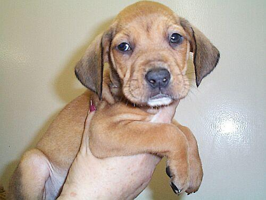

{'labels': 1, 'animal': 'dog', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7AC8FC59BA60>}


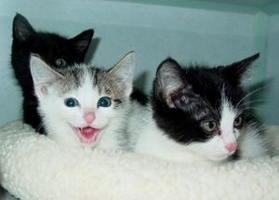

{'labels': 0, 'animal': 'cat', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x215 at 0x7AC8F9B07EB0>}


In [6]:
from datasets import Dataset, Image
from IPython.display import display

small_ds_files_path = "./data/cats_vs_dogs_100_files"

# load the CSV file
loaded_ds = Dataset.from_csv(f"{small_ds_files_path}/data.csv")

# add a new column with the image paths, then cast the image column to an Image type
loaded_ds = loaded_ds.add_column("image", [f"{small_ds_files_path}/{index}.jpg" for index in range(len(loaded_ds))]).cast_column("image", Image())

# inspect the dataset
print(loaded_ds)

# take a look at the first 2 items
for item in loaded_ds.take(2):
    image = item["image"]
    display(image.resize((int(image.width/image.height * 200), 200)))
    print(item)

## Consuming the dataset with an LLM


In [31]:
!pip install -q "google-generativeai>=0.7.2" --upgrade


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [35]:
import google.generativeai as genai

In [40]:
def setup_gemini_token():
    print("Please provide your Gemini API key.")
    gemini_token = input("Please paste your Gemini token here: ")
    genai.configure(api_key=gemini_token)
    
    try:
        list(genai.list_files())
    except Exception as e:
        print("Make sure you have the Gemini API enabled in your Google Cloud Console and the key is correct.")
        print(f"Error: {e}")

    models = [m.name for m in genai.list_models()]
    print(f"Available models:", models)
    

setup_gemini_token()

Please provide your Gemini API key.
Available models: ['models/chat-bison-001', 'models/text-bison-001', 'models/embedding-gecko-001', 'models/gemini-1.0-pro-latest', 'models/gemini-1.0-pro', 'models/gemini-pro', 'models/gemini-1.0-pro-001', 'models/gemini-1.0-pro-vision-latest', 'models/gemini-pro-vision', 'models/gemini-1.5-pro-latest', 'models/gemini-1.5-pro-001', 'models/gemini-1.5-pro-002', 'models/gemini-1.5-pro', 'models/gemini-1.5-pro-exp-0801', 'models/gemini-1.5-pro-exp-0827', 'models/gemini-1.5-flash-latest', 'models/gemini-1.5-flash-001', 'models/gemini-1.5-flash-001-tuning', 'models/gemini-1.5-flash', 'models/gemini-1.5-flash-exp-0827', 'models/gemini-1.5-flash-002', 'models/gemini-1.5-flash-8b', 'models/gemini-1.5-flash-8b-001', 'models/gemini-1.5-flash-8b-latest', 'models/gemini-1.5-flash-8b-exp-0827', 'models/gemini-1.5-flash-8b-exp-0924', 'models/embedding-001', 'models/text-embedding-004', 'models/aqa']


In [37]:
model = genai.GenerativeModel('models/gemini-1.5-flash-002')
model

genai.GenerativeModel(
    model_name='models/gemini-1.5-flash-002',
    generation_config={},
    safety_settings={},
    tools=None,
    system_instruction=None,
    cached_content=None
)

Let's make gemini generate a response containing the animal prediction, count of animals, and some other properties.

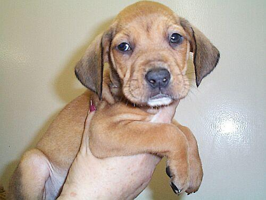

animal='dog' count=1 animals=[AnimalFeatures(color='brown', age=2.0, name='Cuppy Puppy')]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


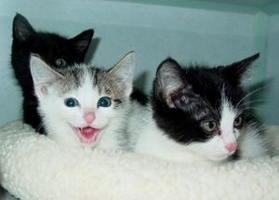

animal='cat' count=3 animals=[AnimalFeatures(color='black', age=2.0, name='Midnight Shadow'), AnimalFeatures(color='grey and white', age=2.0, name='Snowflake Patches'), AnimalFeatures(color='black and white', age=2.0, name='Tuxedo Sam')]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [43]:
from pydantic import BaseModel, Field
from typing import Literal

class AnimalData(BaseModel):
    animal: Literal['cat', 'dog'] = Field(description="The animal in the image")
    count: int = Field(description="The number of animals in the image")

    class AnimalFeatures(BaseModel):
        color: str = Field(description="The color of the animal")
        age: float = Field(description="The estimated age of the animal in years")
        name: str = Field(description="A funny name for the animal. Must be more than one word.")

    animals: list[AnimalFeatures]


def generate_response(image) -> AnimalData:

    response = model.generate_content(
        contents=[
            {
                "role": "user",
                "parts": [
                    {
                        "text": "Look at the image and tell me what animal it is, count them and give each animal a name, color and age."
                    },
                    image
                ]
            }
        ],
        generation_config=genai.GenerationConfig(
            response_mime_type="application/json",
            response_schema=AnimalData,
            max_output_tokens=1024,
            temperature=0.5,
        )
    )

    return AnimalData.model_validate_json(response.text)

for item in loaded_ds.take(2):
    image = item["image"]
    display(image.resize((int(image.width/image.height * 200), 200)))
    response = generate_response(image)
    print(response)
    print('~' * 100)

### Processing the dataset

_Tip: always write your code to incrementally save the progress in case of an error._

We will be incrementally saving the predictions to a JSONL file.  
A JSONL file is a file containing a JSON item per line. You can consider it as a list of JSON objects delimited by new lines.

If the file exists, we count the number of items in order to know how many items we need to skip.

We will be predicting over the dataset, and saving the predictions at each step.

In [52]:
import os
from tqdm.auto import tqdm

# path to the predictions file
predictions_jsonl = "./data/cats_vs_dogs_100_files/predictions.jsonl"

# count the number of items in the predictions file, so we know how many items to skip
if os.path.exists(predictions_jsonl):
    items_to_skip = sum(
        # add 1 if the line is not empty
        1 if _.strip() 
        # otherwise add 0
        else 0
        # for each line in the file
        for _ in open(predictions_jsonl, 'r')
    )
    print(f"Found {items_to_skip} items in the predictions file, will be skipping them.")
else:
    items_to_skip = 0

# open the predictions file in append mode, to add new predictions
with open(predictions_jsonl, 'a') as f:

    # iterate over the dataset, skipping the items that we already have predictions for
    # use tqdm to show the progress bar
    for item in tqdm(loaded_ds.skip(items_to_skip), desc="Predicting"):

        # get prediction from LLM
        image = item["image"]
        generated_data = generate_response(image)

        # save the prediction to the JSONL file
        prediction = generated_data.model_dump_json()
        f.write(prediction + '\n')

        # flush the file to make sure the data is written to the disk
        f.flush()


Predicting: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


### Loading the predictions and merding with the original dataset

In [3]:
from datasets import Dataset
predictions_jsonl = "./data/cats_vs_dogs_100_files/predictions.jsonl"

# loading the predictions from the JSONL file
predicted_ds = Dataset.from_json(predictions_jsonl)
print(predicted_ds)
predicted_ds.features

Dataset({
    features: ['animal', 'count', 'animals'],
    num_rows: 100
})


{'animal': Value(dtype='string', id=None),
 'count': Value(dtype='int64', id=None),
 'animals': [{'color': Value(dtype='string', id=None),
   'age': Value(dtype='float64', id=None),
   'name': Value(dtype='string', id=None)}]}

In [7]:
# adding the predictions to the original dataset
loaded_ds = loaded_ds\
    .add_column("prediction", predicted_ds.data.column('animal'))\
    .add_column("count", predicted_ds.data.column('count'))\
    .add_column("list", predicted_ds.data.column('animals'))

loaded_ds.features

{'labels': Value(dtype='int64', id=None),
 'animal': Value(dtype='string', id=None),
 'image': Image(mode=None, decode=True, id=None),
 'prediction': Value(dtype='string', id=None),
 'count': Value(dtype='int64', id=None),
 'list': [{'color': Value(dtype='string', id=None),
   'age': Value(dtype='float64', id=None),
   'name': Value(dtype='string', id=None)}]}

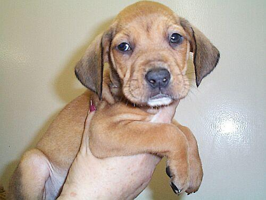

{'animal': 'dog',
 'count': 1,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7030528C9C00>,
 'labels': 1,
 'list': [{'age': 2.0, 'color': 'brown', 'name': 'Cuppy Brown'}],
 'prediction': 'dog'}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


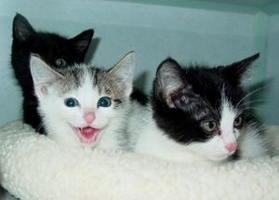

{'animal': 'cat',
 'count': 3,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x215 at 0x7030528790F0>,
 'labels': 0,
 'list': [{'age': 2.0, 'color': 'black', 'name': 'Midnight Shadow'},
          {'age': 2.0, 'color': 'grey and white', 'name': 'Snowdrop Patches'},
          {'age': 2.0, 'color': 'black and white', 'name': 'Inkdrop Twinkle'}],
 'prediction': 'cat'}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [78]:
from IPython.display import display

# let's take a look at the first 2 items
from pprint import pprint
for item in loaded_ds.take(2):
    image = item["image"]
    display(image.resize((int(image.width/image.height * 200), 200)))
    pprint(item)
    print('~' * 100)


#### Save the new dataset to disk

In [79]:
loaded_ds.save_to_disk("./data/cats_vs_dogs_100_with_predictions")

Saving the dataset (1/1 shards): 100%|██████████| 100/100 [00:00<00:00, 12706.93 examples/s]


#### Uploading the dataset to Hugging Face Hub

For interfacing with Hugging Face Hub, we need a token that can write to the hub.  
Create a token here: https://huggingface.co/settings/tokens/new?tokenType=write  
And make sure you keep is secret.

In [83]:
print("Please provide your Hugging Face write access token.")
hf_token = input("Please paste your Hugging Face token here: ")

my_username = "legraphista"
dataset_name = "cats_vs_dogs_100_with_predictions"

pushed = loaded_ds.push_to_hub(f"{my_username}/{dataset_name}", private=True, token=hf_token)
print(pushed)
print(f"You can find the dataset at: https://huggingface.co/datasets/{my_username}/{dataset_name}")

Please provide your Hugging Face write access token.


Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]
No files have been modified since last commit. Skipping to prevent empty commit.


https://huggingface.co/datasets/legraphista/cats_vs_dogs_100_with_predictions/commit/a1f6d669134d561ad8755c1e0a05acf37ad35f4b
You can find the dataset at: https://huggingface.co/datasets/legraphista/cats_vs_dogs_100_with_predictions


## Bonus: let's do some analysis

First, let's convert the dataset to a pandas dataframe.

Pandas cheat sheet: https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf

In [9]:
df = loaded_ds.to_pandas()
df

,labels,animal,image,prediction,count,list
0,1,dog,"{'bytes': None, 'path': './data/cats_vs_dogs_1...",dog,1,"[{'color': 'brown', 'age': 2.0, 'name': 'Cuppy..."
1,0,cat,"{'bytes': None, 'path': './data/cats_vs_dogs_1...",cat,3,"[{'color': 'black', 'age': 2.0, 'name': 'Midni..."
2,1,dog,"{'bytes': None, 'path': './data/cats_vs_dogs_1...",dog,1,"[{'color': 'brown', 'age': 3.0, 'name': 'Cuddl..."
3,0,cat,"{'bytes': None, 'path': './data/cats_vs_dogs_1...",cat,1,"[{'color': 'black', 'age': 3.0, 'name': 'Midni..."
4,0,cat,"{'bytes': None, 'path': './data/cats_vs_dogs_1...",cat,1,"[{'color': 'brown tabby', 'age': 3.0, 'name': ..."
...,...,...,...,...,...,...
95,0,cat,"{'bytes': None, 'path': './data/cats_vs_dogs_1...",cat,1,"[{'color': 'black and white', 'age': 1.0, 'nam..."
96,0,cat,"{'bytes': None, 'path': './data/cats_vs_dogs_1...",cat,1,"[{'color': 'cream', 'age': 3.0, 'name': 'Cream..."
97,0,cat,"{'bytes': None, 'path': './data/cats_vs_dogs_1...",cat,1,"[{'color': 'orange', 'age': 2.0, 'name': 'Pump..."
98,1,dog,"{'bytes': None, 'path': './data/cats_vs_dogs_1...",dog,1,"[{'color': 'brown', 'age': 10.0, 'name': 'Coco..."


In [86]:
# let's see the class distribution
df['animal'].value_counts()

animal
cat    54
dog    46
Name: count, dtype: int64

In [87]:
# and the distribution by number of animals in the image
df['count'].value_counts()

count
1    93
3     3
2     3
6     1
Name: count, dtype: int64

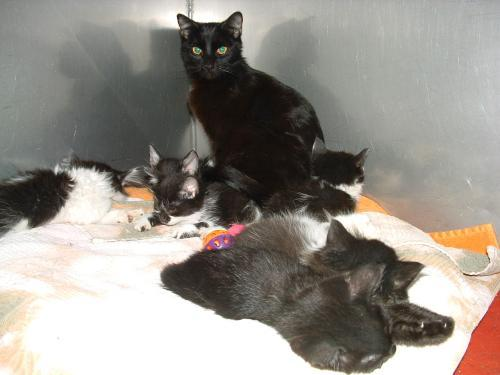

In [90]:
from IPython.display import Image, display

# let's have a look at the image with 6 animals

# get the first row where the count is 6
_6_animals = df[df['count'] == 6].iloc[0]
print(_6_animals)

# get the image path from the image column
image_of_6_animals = _6_animals['image']
display(Image(image_of_6_animals['path']))

In [10]:
# let's have a distribution per colors

# explode the list column into a separate row for each entry in the list
exploded_list = df['list'].explode()

# map the color from the dict
exploded_colors = exploded_list.apply(lambda x: x['color'])
   
exploded_colors.value_counts()

list
black                           20
black and white                 16
brown                           10
grey tabby                       7
white                            5
grey and white                   5
orange and white                 5
light brown                      5
black and tan                    4
gray                             4
orange                           3
brown tabby                      3
grey                             3
brown and black                  2
cream                            2
red                              2
grey, white, orange              1
brown, black, and white          1
gray and white                   1
white with brown patches         1
tricolor                         1
blue-grey-white-black            1
white with black patches         1
white and brown                  1
blue and white                   1
light orange                     1
brindle                          1
cream with light brown spots     1
tortoiseshell  

## Bonus 2: let's do some visualizations with Plotly

In [98]:
!pip install -q plotly nbformat


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [14]:
# explode the entire dataframe by the list column
exploded_df = df.explode('list')

# map the age from the dict to the age column
exploded_df['age'] = exploded_df['list'].apply(lambda x: x['age'])

exploded_df

,labels,animal,image,prediction,count,list,age
0,1,dog,"{'bytes': None, 'path': './data/cats_vs_dogs_1...",dog,1,"{'color': 'brown', 'age': 2.0, 'name': 'Cuppy ...",2.0
1,0,cat,"{'bytes': None, 'path': './data/cats_vs_dogs_1...",cat,3,"{'color': 'black', 'age': 2.0, 'name': 'Midnig...",2.0
1,0,cat,"{'bytes': None, 'path': './data/cats_vs_dogs_1...",cat,3,"{'color': 'grey and white', 'age': 2.0, 'name'...",2.0
1,0,cat,"{'bytes': None, 'path': './data/cats_vs_dogs_1...",cat,3,"{'color': 'black and white', 'age': 2.0, 'name...",2.0
2,1,dog,"{'bytes': None, 'path': './data/cats_vs_dogs_1...",dog,1,"{'color': 'brown', 'age': 3.0, 'name': 'Cuddle...",3.0
...,...,...,...,...,...,...,...
95,0,cat,"{'bytes': None, 'path': './data/cats_vs_dogs_1...",cat,1,"{'color': 'black and white', 'age': 1.0, 'name...",1.0
96,0,cat,"{'bytes': None, 'path': './data/cats_vs_dogs_1...",cat,1,"{'color': 'cream', 'age': 3.0, 'name': 'Cream ...",3.0
97,0,cat,"{'bytes': None, 'path': './data/cats_vs_dogs_1...",cat,1,"{'color': 'orange', 'age': 2.0, 'name': 'Pumpk...",2.0
98,1,dog,"{'bytes': None, 'path': './data/cats_vs_dogs_1...",dog,1,"{'color': 'brown', 'age': 10.0, 'name': 'Coco ...",10.0


#### Histogram of the age distribution by animal

In [17]:
import plotly.graph_objects as go

# Create separate histograms for cats and dogs
fig = go.Figure()

# for each unique animal in the dataset
for animal in exploded_df.animal.unique():

    # get the data for the animal
    animal_data = exploded_df[exploded_df['animal'] == animal]
    
    # add a histogram to the figure
    fig.add_trace(go.Histogram(
        x=animal_data['age'],
        name=animal.capitalize(),
        nbinsx=20,
        opacity=0.7
    ))

# Customize the layout
fig.update_layout(
    title="Distribution of Animal Ages by Species",
    xaxis_title="Age (years)",
    yaxis_title="Frequency",
    bargap=0.1,  # Add some gap between bars
    barmode='group'  # Group the histograms side by side instead of overlaying
)

# Add a legend
fig.update_layout(legend_title="Animal Type")

# Show the plot
fig.show()



#### Violin plot of the age distribution by animal

In [18]:
import plotly.graph_objects as go

# Create a violin plot with dots for cats and dogs
fig = go.Figure()

# for each unique animal in the dataset
for animal in exploded_df.animal.unique():
    # get the data for the animal
    animal_data = exploded_df[exploded_df['animal'] == animal]
    
    # add a violin plot to the figure
    fig.add_trace(go.Violin(
        x=animal_data['animal'],
        y=animal_data['age'],
        name=animal.capitalize(),
        box_visible=True,
        meanline_visible=True,
        points='all'  # This will show all data points
    ))

# Customize the layout
fig.update_layout(
    title="Distribution of Animal Ages by Species",
    xaxis_title="Animal Type",
    yaxis_title="Age (years)",
    violinmode='group'  # Group the violin plots side by side
)

# Add a legend
fig.update_layout(legend_title="Animal Type")

# Show the plot
fig.show()


### Pie chart of the color distribution by animal

In [21]:
# map the color from the dict to the color column
exploded_df['color'] = exploded_df['list'].apply(lambda x: x['color'])

# Create a pie chart for each animal type
for animal in exploded_df['animal'].unique():
    # Filter the data for the current animal
    animal_data = exploded_df[exploded_df['animal'] == animal]
    
    # Count the occurrences of each color
    color_counts = animal_data['color'].value_counts()
    
    # Create the pie chart
    fig = go.Figure(data=[go.Pie(
        labels=color_counts.index,
        values=color_counts.values,
        hole=.3
    )])
    
    # Update layout
    fig.update_layout(
        title_text=f"Color Distribution of {animal.capitalize()}s",
        title_x=0.5,
        title_y=0.95,
        annotations=[dict(text=animal.capitalize(), x=0.5, y=0.5, font_size=20, showarrow=False)]
    )
    
    # Show the plot
    fig.show()

# Create a combined pie chart for all animals
color_counts_all = exploded_df['color'].value_counts()

fig = go.Figure(data=[go.Pie(
    labels=color_counts_all.index,
    values=color_counts_all.values,
    hole=.3
)])

fig.update_layout(
    title_text="Color Distribution of All Animals",
    title_x=0.5,
    title_y=0.95,
    annotations=[dict(text='All', x=0.5, y=0.5, font_size=20, showarrow=False)]
)

fig.show()
